In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data
df_id= pd.read_csv('./data/channel_ids_sampled.csv')
df_channels = pd.read_feather('./data/df_channels_en_sampled.feather')
df_timeseries = pd.read_feather('./data/df_timeseries_en_sampled.feather')
df_comments = pd.read_feather('./data/num_comments_sampled.feather')
df_metadata = pd.read_feather('./data/yt_metadata_en_sampled.feather')

In [2]:
# View column names and data types of each dataframe
for df_name, df in [('df_id', df_id), 
                    ('df_channels', df_channels),
                    ('df_timeseries', df_timeseries), 
                    ('df_comments', df_comments),
                    ('df_metadata', df_metadata)]:
    print(f"\n{df_name} columns:")
    print(df.info())


df_id columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  13633 non-null  object
dtypes: object(1)
memory usage: 106.6+ KB
None

df_channels columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_cc         13633 non-null  object 
 1   join_date           13633 non-null  object 
 2   channel             13633 non-null  object 
 3   name_cc             13633 non-null  object 
 4   subscribers_cc      13633 non-null  int64  
 5   videos_cc           13633 non-null  int64  
 6   subscriber_rank_sb  13633 non-null  float64
 7   weights             13633 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 852.2+ KB
None

df_timeseries columns:
<clas

In [3]:
# Check missing values in each dataframe
display(pd.isna(df_channels).sum())
display(pd.isna(df_channels).sum())
display(pd.isna(df_timeseries).sum())
display(pd.isna(df_comments).sum())
display(pd.isna(df_metadata).sum())

category_cc           0
join_date             0
channel               0
name_cc               0
subscribers_cc        0
videos_cc             0
subscriber_rank_sb    0
weights               0
dtype: int64

category_cc           0
join_date             0
channel               0
name_cc               0
subscribers_cc        0
videos_cc             0
subscriber_rank_sb    0
weights               0
dtype: int64

channel         0
category        0
datetime        0
views           0
delta_views     0
subs            0
delta_subs      0
videos          0
delta_videos    0
activity        0
dtype: int64

display_id    0
num_comms     0
dtype: int64

categories            0
channel_id            0
dislike_count    171758
display_id            0
duration              0
like_count       171758
upload_date           0
view_count           33
dtype: int64

In [4]:
# fill missing values 
def fill_channel_means(df, columns_to_fill):
    """
    Fill NaN values in specified columns with the mean value of the same channel_id
    """
    # Create a copy to avoid modifying the original DataFrame
    df_filled = df.copy()
    
    # Calculate means for each channel_id
    channel_means = df.groupby('channel_id')[columns_to_fill].transform('mean')
    
    # Fill NaN values with channel means
    for col in columns_to_fill:
        df_filled[col] = df_filled[col].fillna(channel_means[col])
        
        # If any NaN values remain (for channels with all NaN values),
        # fill with the overall mean of the column
        if df_filled[col].isna().any():
            overall_mean = df[col].mean()
            df_filled[col] = df_filled[col].fillna(overall_mean)
    
    return df_filled

df_metadata=fill_channel_means(df_metadata, ['dislike_count','like_count' ,'view_count'])
display(pd.isna(df_metadata).sum())

categories       0
channel_id       0
dislike_count    0
display_id       0
duration         0
like_count       0
upload_date      0
view_count       0
dtype: int64

# Jack of all trades or master of one 
We wonder if YouTube creators should stick to one topic or mix it up. We can investigate this by analyzing three key aspects: the impact of content diversity on channel growth and engagement, long-term performance comparison between specialized and diversified channels, and common characteristics of successful diversification strategies

In [5]:
def preprocess_data(df_metadata, df_timeseries, min_videos=0):
    """Preprocess data, filter and aggregate in advance"""
    # 1. Calculate number of videos for each channel
    channel_video_counts = df_metadata['channel_id'].value_counts()
    
    # 2. Select channels that meet minimum video requirement
    valid_channels = channel_video_counts[channel_video_counts >= min_videos].index
    
    # 3. Filter data
    filtered_metadata = df_metadata[df_metadata['channel_id'].isin(valid_channels)].copy()
    filtered_timeseries = df_timeseries[df_timeseries['channel'].isin(valid_channels)].copy()
    
    return filtered_metadata, filtered_timeseries

def calculate_channel_metrics(filtered_metadata,filtered_timeseries):
    """Calculate channel metrics"""
    # Calculate basic metrics grouped by channel
    channel_metrics = filtered_metadata.groupby('channel_id').agg({
        'view_count': 'mean',
        'like_count': 'mean',
        'categories': lambda x: list(x)
    }).reset_index()
    
    # Calculate engagement rate
    channel_metrics['engagement_rate'] = channel_metrics['like_count'] / channel_metrics['view_count']
    
    # Calculate category distribution and diversity (information entropy) for each channel
    def calculate_diversity(categories):
        category_counts = pd.Series(categories).value_counts()
        proportions = category_counts / len(categories)
        return -np.sum(proportions * np.log(proportions))
    
    channel_metrics['diversity'] = channel_metrics['categories'].apply(calculate_diversity)
    channel_metrics['num_categories'] = channel_metrics['categories'].apply(lambda x: len(set(x)))
    channel_metrics['main_category'] = channel_metrics['categories'].apply(lambda x: pd.Series(x).mode()[0])
    channel_metrics['main_category_ratio'] = channel_metrics['categories'].apply(
        lambda x: pd.Series(x).value_counts().iloc[0] / len(x)
    )
    
    # Calculate growth metrics grouped by channel
    growth_metrics = df_timeseries.groupby('channel').agg({
        'delta_subs': ['sum', 'count'],  # Total growth and number of data points
        'delta_views': 'sum',
        'views': 'last',  # Latest views
        'subs': 'last'    # Latest subscribers
    })
    
    growth_metrics.columns = ['sub_growth', 'weeks', 'view_growth', 'final_views', 'final_subs']
    growth_metrics['weekly_sub_growth'] = growth_metrics['sub_growth'] / growth_metrics['weeks']
    growth_metrics['weekly_view_growth'] = growth_metrics['view_growth'] / growth_metrics['weeks']
    
    # Merge metrics
    merged_metrics = channel_metrics.merge(
        growth_metrics, 
        left_on='channel_id', 
        right_index=True,
        how='left'
    ).dropna()
    
    # Add channel strategy labels
    merged_metrics['strategy'] = pd.cut(
        merged_metrics['main_category_ratio'],
        bins=[0, 0.4, 0.7, 1],
        labels=['Diversified', 'Mixed', 'Specialized']
    )
    
    return merged_metrics


print("Preprocessing data...")
filtered_metadata, filtered_timeseries = preprocess_data(df_metadata, df_timeseries, 0)
    
print("Calculating channel metrics...")
merged_metrics = calculate_channel_metrics(filtered_metadata, filtered_timeseries)
print(merged_metrics.info())

Preprocessing data...
Calculating channel metrics...
<class 'pandas.core.frame.DataFrame'>
Index: 13345 entries, 0 to 13632
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   channel_id           13345 non-null  object  
 1   view_count           13345 non-null  float64 
 2   like_count           13345 non-null  float64 
 3   categories           13345 non-null  object  
 4   engagement_rate      13345 non-null  float64 
 5   diversity            13345 non-null  float64 
 6   num_categories       13345 non-null  int64   
 7   main_category        13345 non-null  object  
 8   main_category_ratio  13345 non-null  float64 
 9   sub_growth           13345 non-null  float64 
 10  weeks                13345 non-null  float64 
 11  view_growth          13345 non-null  float64 
 12  final_views          13345 non-null  float64 
 13  final_subs           13345 non-null  float64 
 14  weekly_sub_growth    1

In [6]:
def identify_patterns(merged_metrics, percentile=75):
    """Identify patterns of successful channels"""
    
    # Define multi-dimensional success thresholds
    view_threshold = merged_metrics['view_count'].quantile(percentile/100)
    engagement_threshold = merged_metrics['engagement_rate'].quantile(percentile/100)
    sub_growth_threshold = merged_metrics['weekly_sub_growth'].quantile(percentile/100)
    view_growth_threshold = merged_metrics['weekly_view_growth'].quantile(percentile/100)
    
    # Identify successful channels
    successful_channels = merged_metrics[
        (merged_metrics['view_count'] >= view_threshold) |
        (merged_metrics['engagement_rate'] >= engagement_threshold) |
        (merged_metrics['weekly_sub_growth'] >= sub_growth_threshold) |
        (merged_metrics['weekly_view_growth'] >= view_growth_threshold)
    ]
    
    # Calculate characteristics
    patterns = {
        'avg_diversity': successful_channels['diversity'].mean(),
        'avg_categories': successful_channels['num_categories'].mean(),
        'main_category_ratio': successful_channels['main_category_ratio'].mean(),
        'channel_count': len(successful_channels),
        'avg_views': successful_channels['view_count'].mean(),
        'avg_engagement': successful_channels['engagement_rate'].mean(),
        'avg_weekly_sub_growth': successful_channels['weekly_sub_growth'].mean(),
        'avg_weekly_view_growth': successful_channels['weekly_view_growth'].mean(),
        'avg_weeks_active': successful_channels['weeks'].mean(),
    }   
    
    # Analyze by strategy groups
    for strategy in successful_channels['strategy'].unique():
        strategy_channels = successful_channels[successful_channels['strategy'] == strategy]
        patterns[strategy] = {
            'proportion': len(strategy_channels) / len(successful_channels),
            'avg_weekly_sub_growth': strategy_channels['weekly_sub_growth'].mean(),
            'avg_weekly_view_growth': strategy_channels['weekly_view_growth'].mean(),
            'avg_diversity': strategy_channels['diversity'].mean()
        }
    
    print("\n=== Content Strategy Analysis Results ===")
    print(f"\nNumber of successful channels: {patterns['channel_count']}")
    print(f"Average diversity index: {patterns['avg_diversity']:.2f}")
    print(f"Average number of categories: {patterns['avg_categories']:.1f}")
    print(f"Average main category ratio: {patterns['main_category_ratio']*100:.1f}%")
    print(f"Average views: {patterns['avg_views']:,.0f}")
    print(f"Average engagement: {patterns['avg_engagement']:.3f}")
    print(f"Average weekly subscriber growth: {patterns['avg_weekly_sub_growth']:.1f}")
    print(f"Average weekly view growth: {patterns['avg_weekly_view_growth']:.1f}")
    print(f"Average active weeks: {patterns['avg_weeks_active']:.1f}")
    print("\nSuccessful Strategy Characteristics:")
    for strategy, stats in patterns.items():
        if isinstance(stats, dict):  # Ensure it's strategy data rather than other statistics
            print(f"\nStrategy: {strategy}")
            print(f"Proportion: {stats['proportion']:.1%}")
            print(f"Weekly average subscriber growth: {stats['avg_weekly_sub_growth']:.1f}")
            print(f"Weekly average view growth: {stats['avg_weekly_view_growth']:,.0f}")
            print(f"Content diversity: {stats['avg_diversity']:.2f}")
    
    return patterns, successful_channels

print("Identifying success patterns...")
patterns, successful_channels = identify_patterns(merged_metrics)

Identifying success patterns...

=== Content Strategy Analysis Results ===

Number of successful channels: 7471
Average diversity index: 0.33
Average number of categories: 2.8
Average main category ratio: 87.2%
Average views: 664,421
Average engagement: 0.024
Average weekly subscriber growth: 2422.2
Average weekly view growth: 676904.2
Average active weeks: 132.3

Successful Strategy Characteristics:

Strategy: Specialized
Proportion: 81.4%
Weekly average subscriber growth: 2530.7
Weekly average view growth: 717,751
Content diversity: 0.18

Strategy: Mixed
Proportion: 17.2%
Weekly average subscriber growth: 1988.3
Weekly average view growth: 507,182
Content diversity: 0.91

Strategy: Diversified
Proportion: 1.5%
Weekly average subscriber growth: 1478.0
Weekly average view growth: 396,569
Content diversity: 1.53


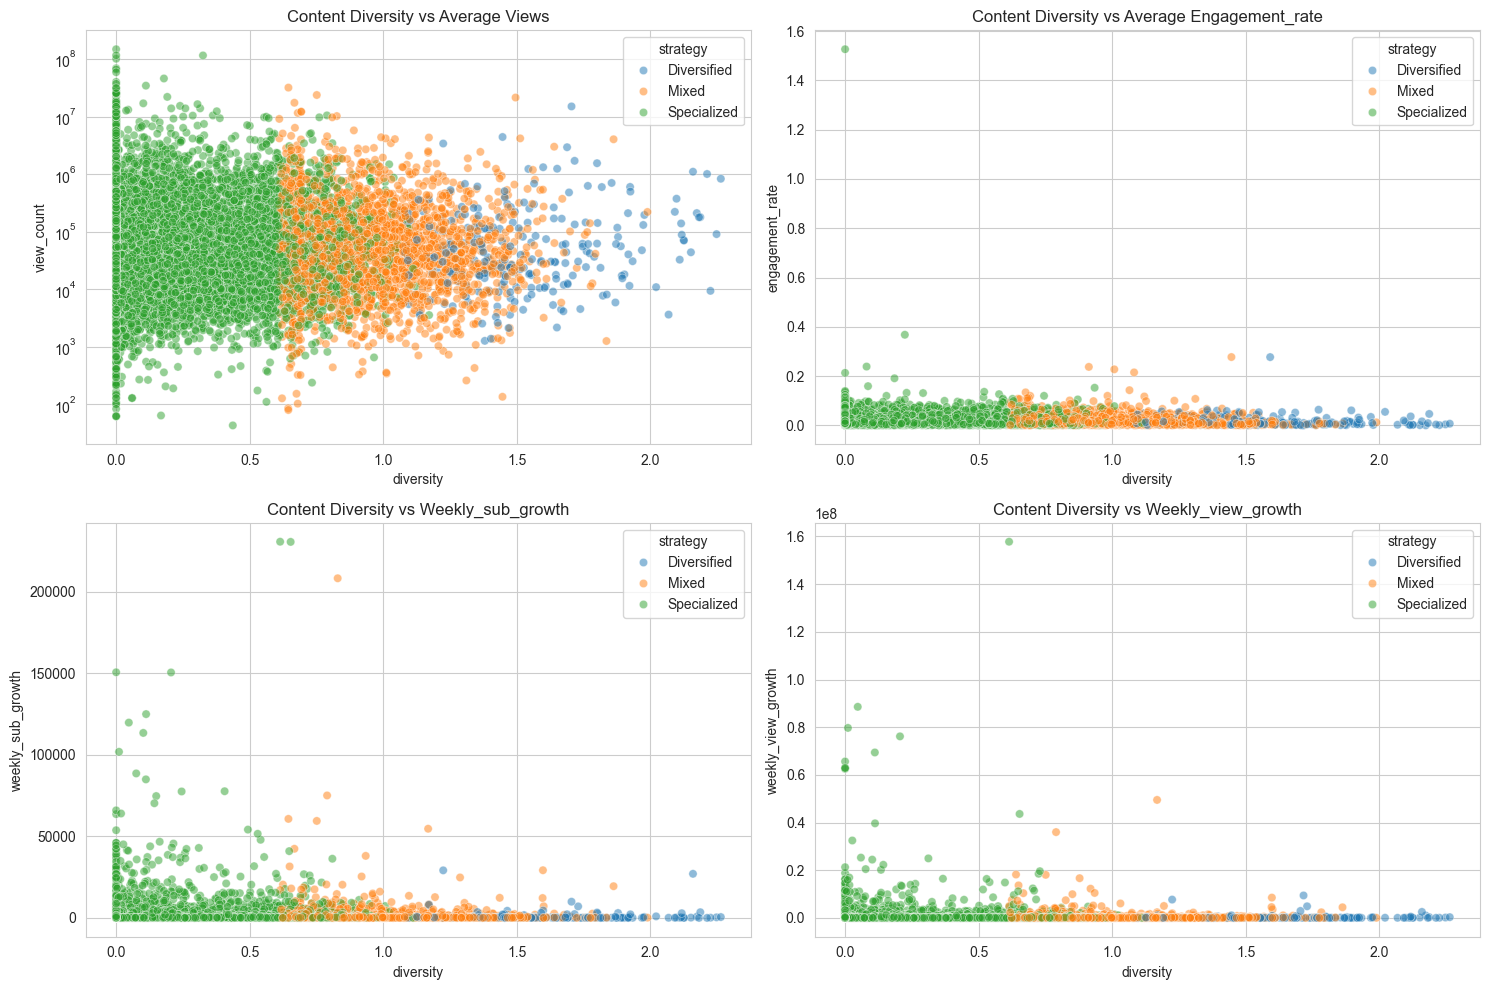

In [7]:
def diversity_plot_insights(merged_metrics):
    """Create key insight visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Diversity vs Views
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='view_count',
        hue='strategy',
        alpha=0.5,
        ax=axes[0,0]
    )
    axes[0,0].set_title('Content Diversity vs Average Views')
    axes[0,0].set_yscale('log')  # Use log scale

    # 2. Number of categories vs Engagement
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='engagement_rate',
        hue='strategy',
        alpha=0.5,
        ax=axes[0,1]
    )
    axes[0,1].set_title('Content Diversity vs Average Engagement_rate')

    # 3. Growth rate vs Diversity
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='weekly_sub_growth',
        hue='strategy',
        alpha=0.5,
        ax=axes[1,0]
    )
    axes[1,0].set_title('Content Diversity vs Weekly_sub_growth')

    # 4. Main category ratio vs Growth rate
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='weekly_view_growth',
        hue='strategy',
        alpha=0.5,
        ax=axes[1,1]
    )
    axes[1,1].set_title('Content Diversity vs Weekly_view_growth')

    plt.tight_layout()
    return fig


plot = diversity_plot_insights(merged_metrics)
plt.show()

# Analysis of video duration
We are interested in the impact of video duration. Will people prefer a longer video as they may get more knowledge, or they prefer a short video for passing time? We can explore this by investigating three aspects: optimal video length for different categories, the impact of video length on viewer engagement and channel growth, and the evolution of audience preferences for video length over time. Also, we are going to develop a method to evaluate the popular degree of a video, then focus on the relationship between video duration and popular degree.


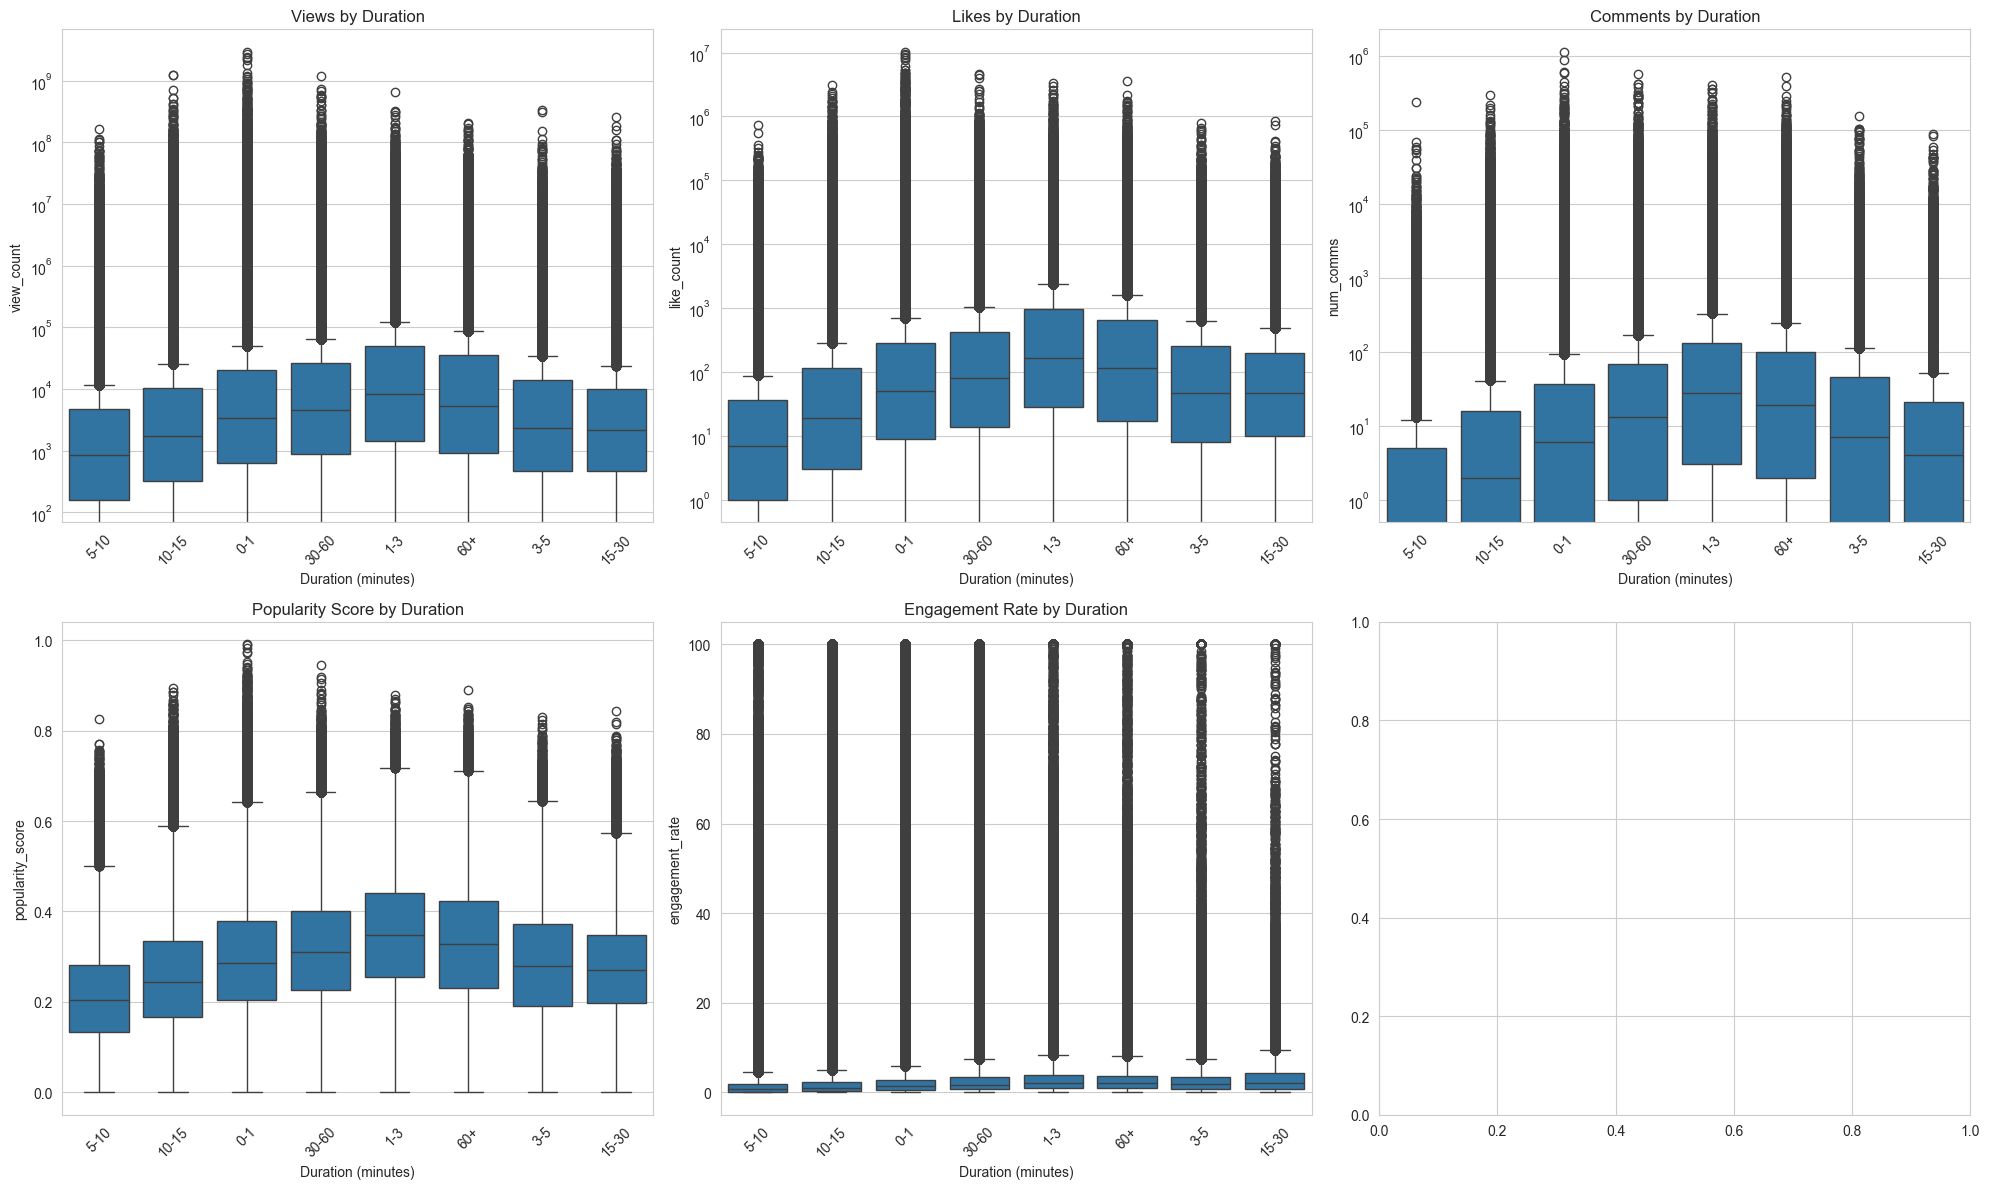

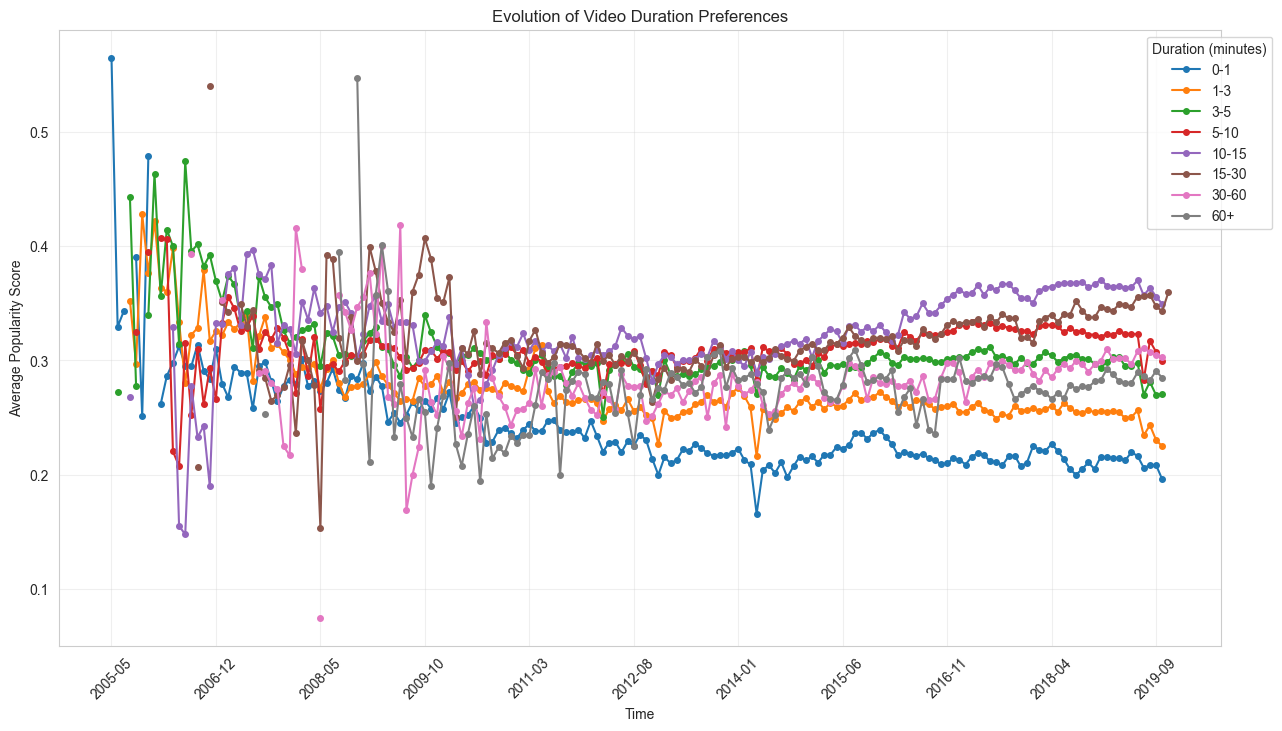

In [8]:
def calculate_popularity_score_vectorized(df):
    """
    Vectorized calculation of popularity score
    """

    view_score = np.log1p(df['view_count'])
    like_score = np.log1p(df['like_count'])
    comment_score = np.log1p(df['num_comms'])


    max_view = np.log1p(df['view_count'].max())
    max_like = np.log1p(df['like_count'].max())
    max_comment = np.log1p(df['num_comms'].max())


    score = (
            0.5 * (view_score / max_view) +
            0.3 * (like_score / max_like) +
            0.2 * (comment_score / max_comment)
    )

    return score

def analyze_duration_metrics():
    """
    Analyze relationships between video duration and various performance metrics
    """
    # Select only needed columns for merging to reduce memory usage
    df_metadata_subset = df_metadata[['display_id', 'duration', 'view_count', 'like_count', 'upload_date']].copy()
    df_comments_subset = df_comments[['display_id', 'num_comms']].copy()

    df_analysis = pd.merge(
        df_metadata_subset,
        df_comments_subset,
        on='display_id',
        how='left'
    )

    # Convert duration to minutes
    df_analysis['duration_minutes'] = df_analysis['duration'] / 60

    # Vectorized calculation of popularity score
    df_analysis['popularity_score'] = calculate_popularity_score_vectorized(df_analysis)

    # Create duration categories
    duration_bins = [0, 1, 3, 5, 10, 15, 30, 60, np.inf]
    duration_labels = ['0-1', '1-3', '3-5', '5-10', '10-15', '15-30', '30-60', '60+']
    df_analysis['duration_category'] = pd.cut(
        df_analysis['duration_minutes'],
        bins=duration_bins,
        labels=duration_labels
    )

    return df_analysis

def plot_engagement_metrics(df_analysis):
    """
    Plot engagement metric charts
    """
    plot_data = df_analysis

    # Calculate engagement rate
    plot_data['engagement_rate'] = (plot_data['like_count'] / plot_data['view_count'] * 100).fillna(0)
    plot_data['engagement_rate'] = plot_data['engagement_rate'].clip(upper=100)

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    metrics = ['view_count', 'like_count', 'num_comms', 'popularity_score', 'engagement_rate']
    titles = ['Views by Duration', 'Likes by Duration', 'Comments by Duration', 'Popularity Score by Duration', 'Engagement Rate by Duration']

    for i, (metric, title) in enumerate(zip(metrics[:5], titles)):
        row = i // 3
        col = i % 3

        # Create box plot
        sns.boxplot(
            x='duration_category',
            y=metric,
            data=plot_data,
            ax=axes[row, col]
        )

        # Set x-axis ticks and labels correctly
        axes[row, col].set_xticks(range(len(plot_data['duration_category'].unique())))
        axes[row, col].set_xticklabels(
            plot_data['duration_category'].unique(),
            rotation=45
        )

        axes[row, col].set_title(title)
        if metric in ['view_count', 'like_count', 'num_comms']:
            axes[row, col].set_yscale('log')
        axes[row, col].set_xlabel('Duration (minutes)')

    plt.tight_layout()

    # Calculate statistics, explicitly specify observed parameter
    engagement_stats = df_analysis.groupby('duration_category', observed=True)['engagement_rate'].agg([
        'mean', 'median', 'std'
    ]).round(2)

    return fig, engagement_stats

def analyze_temporal_trends(df_analysis):
    # Pre-calculate year and month
    df_analysis['year_month'] = df_analysis['upload_date'].dt.to_period('M')

    # Explicitly specify observed parameter
    temporal_trends = (df_analysis.groupby(
        ['year_month', 'duration_category'],
        observed=True
    )['popularity_score'].mean().reset_index())

    plt.figure(figsize=(15, 8))

    # Reshape data using pivot_table
    pivot_data = temporal_trends.pivot(
        index='year_month',
        columns='duration_category',
        values='popularity_score'
    )

    # Plot trend lines
    for col in pivot_data.columns:
        if not pivot_data[col].empty:
            plt.plot(range(len(pivot_data)), pivot_data[col], label=col, marker='o', markersize=4)

    # Set x-axis labels
    step = max(len(pivot_data) // 10, 1)
    plt.xticks(
        range(0, len(pivot_data), step),
        [str(idx) for idx in pivot_data.index[::step]],
        rotation=45
    )

    plt.title('Evolution of Video Duration Preferences')
    plt.xlabel('Time')
    plt.ylabel('Average Popularity Score')
    plt.legend(title='Duration (minutes)', bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)

    return plt

# Run analysis
df_analysis = analyze_duration_metrics()
fig_engagement, stats = plot_engagement_metrics(df_analysis)
plt_trends = analyze_temporal_trends(df_analysis)